In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import os, sys
import math
import pickle
import notebook_utils as nbutils
import data_utils as datutil
import datetime as dt
import hmc
from models import *
import gpytorch
from notebook_utils import *
import mici

In [2]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

class bayes_fc_block(nn.Module):
    def __init__(self, input_dim, output_dim, device):
        super(bayes_fc_block, self).__init__()
        self.register_parameter('fc_w', Parameter(torch.Tensor(input_dim, output_dim)))
        self.register_parameter('fc_b', Parameter(torch.Tensor(output_dim)))
        self.device = device
        self.ind = input_dim
        self.outd = output_dim
        param_dict = dict(self.named_parameters())
        stdv = 1. / math.sqrt(input_dim)
        param_dict['fc_w'].data.uniform_(-stdv, stdv)
        param_dict['fc_b'].data.uniform_(-stdv, stdv)

    def forward(self, x):
        param_dict = dict(self.named_parameters())
        w = param_dict['fc_w']
        b = param_dict['fc_b']
        x = F.linear(x, w.t(), b)
        return x    
    
    def change_param_to(self, flattened_param):
        param_dict = dict(self.named_parameters())
        w_data = torch.tensor(flattened_param[:self.ind*self.outd].reshape(self.ind, self.outd))
        b_data = torch.tensor(flattened_param[self.ind*self.outd:].reshape(self.outd))
        param_dict['fc_w'].data = w_data.type(torch.FloatTensor).to(self.device)
        param_dict['fc_b'].data = b_data.type(torch.FloatTensor).to(self.device)
        
    def return_grads(self):
        param_dict = dict(self.named_parameters())
        w_grad = param_dict['fc_w'].grad.cpu()
        b_grad = param_dict['fc_b'].grad.cpu()
        w_grad = w_grad.detach().numpy().flatten()
        b_grad = b_grad.detach().numpy().flatten()
        return np.concatenate((w_grad, b_grad), axis=0)
    
    def return_paramval(self):
        param_dict = dict(self.named_parameters())
        w_data = param_dict['fc_w'].data.cpu()
        b_data = param_dict['fc_b'].data.cpu()
        w_data = w_data.detach().numpy().flatten()
        b_data = b_data.detach().numpy().flatten()
        return np.concatenate((w_data, b_data), axis=0)


class feature(nn.Module):
    def __init__(self, base_feature, fc_layers, device, trainloader, loss_dict=None):
        super(feature, self).__init__()
        self.base_layer = base_feature
        self.fc_architecture = fc_layers
        self.device = device
        self.trainloader = trainloader
        self.loss_dict = loss_dict
        if len(fc_layers) > 0:
            self.linear_list = [bayes_fc_block(fc_layers[i], fc_layers[i+1], device) for i in range(len(fc_layers)-1)]
            self.bayes_fc_blocks = nn.Sequential(*self.linear_list)
        
    def forward(self, x, labels, samples):
        # print(x.size())
        x = self.base_layer(x)
        out = 0
        batch_size = x.size()[0]
        num_sample = len(samples)
        
        for sample in samples:
            current_index = 0
            for layer_count in range(len(self.linear_list)):
                layer_len = self.fc_architecture[layer_count+1] * (self.fc_architecture[layer_count] + 1)
                flattened_param = sample[current_index: current_index + layer_len]
                self.linear_list[layer_count].change_param_to(flattened_param)
                current_index += layer_len
                
            last_layer = self.bayes_fc_blocks(x)
            if self.loss_dict is None:
                probs = F.softmax(last_layer, dim=1)
                class_logprob = torch.log(torch.gather(probs, dim=1, index=labels.reshape((batch_size, 1))))
                out -= torch.sum(class_logprob) / num_sample
            else:
                for loss_fn, weight in loss_dict.items():
                    out += weight * loss_fn(last_layer, labels) / num_sample
                
        if num_sample==0:
            last_layer = self.bayes_fc_blocks(x)
            if self.loss_dict is None:
                probs = F.softmax(last_layer, dim=1)
                class_logprob = torch.log(torch.gather(probs, dim=1, index=labels.reshape((batch_size, 1))))
                out -= torch.sum(class_logprob) / batch_size
            else:
                for loss_fn, weight in loss_dict.items():
                    out += weight * loss_fn(last_layer, labels) / batch_size
        
        return out
    
    def infer(self, x, samples):
        x = self.base_layer(x)
        class_prob = torch.zeros((len(samples), x.size()[0], self.fc_architecture[-1]), device=self.device)
        count = 0
        
        for sample in samples:
            current_index = 0
            for layer_count in range(len(self.linear_list)):
                layer_len = self.fc_architecture[layer_count+1] * (self.fc_architecture[layer_count] + 1)
                flattened_param = sample[current_index: current_index + layer_len]
                self.linear_list[layer_count].change_param_to(flattened_param)
                current_index += layer_len
            
            class_outp = self.bayes_fc_blocks(x)
            class_prob[count,:,:] = F.softmax(class_outp, dim=1)
            count += 1
            
        return class_prob
    
    def return_grads(self):
        grads = [layer.return_grads() for layer in self.linear_list]
        return np.concatenate(grads, axis=0)
    
    def return_paramval(self):
        vals = [layer.return_paramval() for layer in self.linear_list]
        return np.concatenate(vals, axis=0)
    
    def potential_energy(self, pos):
    
        total_datasize = len(self.trainloader.dataset)
        pot_energy = 0
        for i, data in enumerate(self.trainloader):
            self.zero_grad()
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            loss = self.forward(inputs, labels, [pos])
            pot_energy += loss.item()
        
        pot_energy += np.sum(pos**2) / (2.0)
        return pot_energy

    def gradient_potential_energy(self, pos):

        total_datasize = len(self.trainloader.dataset)
        pot_energy = 0
        grad_pot_energy = np.zeros(pos.shape)
        for i, data in enumerate(self.trainloader):
            self.zero_grad()
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            loss = self.forward(inputs, labels, [pos])
            loss.backward()
            pot_energy += loss.item()
            grad_pot_energy += self.return_grads()
            
        pot_energy += np.sum(pos**2) / (2.0)
        grad_pot_energy += pos

        return grad_pot_energy, pot_energy

In [3]:
# Data loader initialization
# trainloader = datutil.generate_dataloaders('CIFAR10_TRAIN', batch_size=100, shuffle=False, num_workers=2) #, end=48000)
# testloader = datutil.generate_dataloaders('CIFAR10_TEST', batch_size=100, shuffle=False, num_workers=2)
# trainloader = datutil.generate_dataloaders('ENCODED256_D164_CIFAR10_TRAIN', batch_size=500, shuffle=False, num_workers=2)
# testloader = datutil.generate_dataloaders('ENCODED256_D164_CIFAR10_TEST', batch_size=200, shuffle=False, num_workers=2)
trainloader = datutil.generate_dataloaders('48000RESNET164_CIFAR10_TRAIN', batch_size=300, shuffle=False, num_workers=2)
testloader = datutil.generate_dataloaders('48000RESNET164_CIFAR10_TEST', batch_size=200, shuffle=False, num_workers=2)

device = torch.device('cuda:1')

In [10]:
fc_layer_setup = [256, 10]
# base_model = PreResNet(num_classes=fc_layer_setup[-1], depth=164)
base_model = Identity()
# base_model.fc = Identity()
loss_dict = None
loss1 = nn.CrossEntropyLoss(reduction='sum')
loss2 = limiting_ECE_loss(reduction='sum')
loss1.to(device);loss2.to(device)
loss_dict = {loss1: 1.} #, loss2: 10.}
final_model = feature(base_model, fc_layer_setup, device, trainloader) #, loss_dict)
final_model.to(device)

feature(
  (base_layer): Identity()
  (bayes_fc_blocks): Sequential(
    (0): bayes_fc_block()
  )
)

In [11]:
running_loss = 0
optimizer = torch.optim.SGD(final_model.parameters(), weight_decay=0.0003, lr=0.6, momentum=0.9)

for epoch in range(0, 3):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        loss = final_model(inputs, labels, [])
        loss.sum().backward()
        optimizer.step()
        running_loss = 0.9*running_loss + 0.1*loss.item() if running_loss != 0 else loss.item()

    print("Epoch:", epoch, 'Loss:', loss.item())

Epoch: 0 Loss: 0.546180784702301
Epoch: 1 Loss: 0.37317922711372375
Epoch: 2 Loss: 0.3485577404499054


In [12]:
rng = np.random.RandomState(seed=1234)
system = hmc.systems.EuclideanMetricSystem(pot_energy=final_model.potential_energy,
                                           grad_pot_energy=final_model.gradient_potential_energy)
integrator = hmc.integrators.LeapfrogIntegrator(system, step_size=0.05)
sampler = hmc.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
chains, chain_stats = sampler.sample_chain(
    n_sample=20, init_state=final_model.return_paramval(),
    chain_var_funcs={'pos': lambda state: state.pos,
                     'pot_energy': lambda state: system.pot_energy(state),
                     'kin_energy': lambda state: system.kin_energy(state)})

In [ ]:
with open('chains2.pkl', 'wb') as chainfile:
    pickle.dump(chains['pos'], chainfile)
# with open('chains.pkl', 'rb') as chainfile:
#     params = pickle.load(chainfile)

0.0


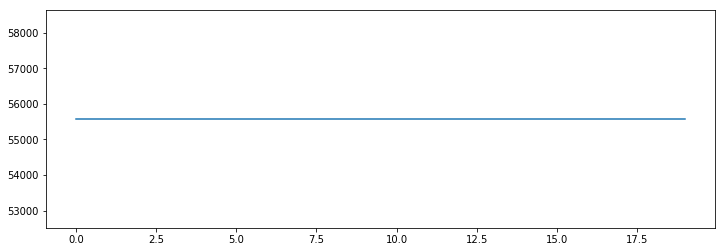

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(chains['pot_energy'])
print(chain_stats['accept_prob'].mean())

In [ ]:
# calculate accuracy and ECE on the test dataset
accuracy, ece, sce = nbutils.validate(model=final_model, dataloader=testloader, device=device, 
                                      params=[np.mean(chains['pos'], axis=0)])

In [ ]:
import imp
imp.reload(nbutils)

In [ ]:
np.mean(chains['pos'], axis=0)